In [40]:
#coding:UTF-8
import os
import sys
import numpy as np
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from scipy import sparse
import shutil
from tqdm.notebook import tqdm

import anndata
import scanpy as sc
from scipy import sparse

sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

scanpy==1.7.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.9.1 leidenalg==0.8.3


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
data_root_dir = '/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/stCluster/data/HumanPilot_spatial.h5ads/scanpy'

h5ad_fname = os.path.join(data_root_dir, '151673.h5ad')


In [63]:
# 
adata = sc.read_h5ad(h5ad_fname)
# QC
# https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [64]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

<AxesSubplot:xlabel='n_genes_by_counts'>

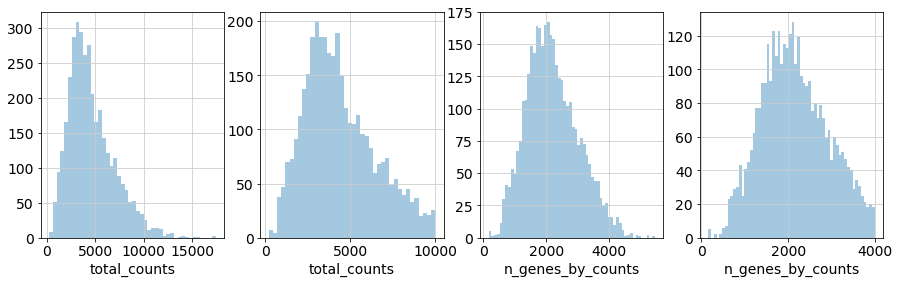

In [65]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [66]:
# sc.pp.filter_cells(adata, min_counts=100)
# sc.pp.filter_cells(adata, max_counts=7500)
# adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 3639


filtered out 16960 genes that are detected in less than 10 cells
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [67]:
adata

AnnData object with n_obs × n_vars = 3639 × 16578
    obs: 'in_tissue', 'array_row', 'array_col', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [68]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [101]:
adata.obsm.keys()

KeysView(AxisArrays with keys: spatial)

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


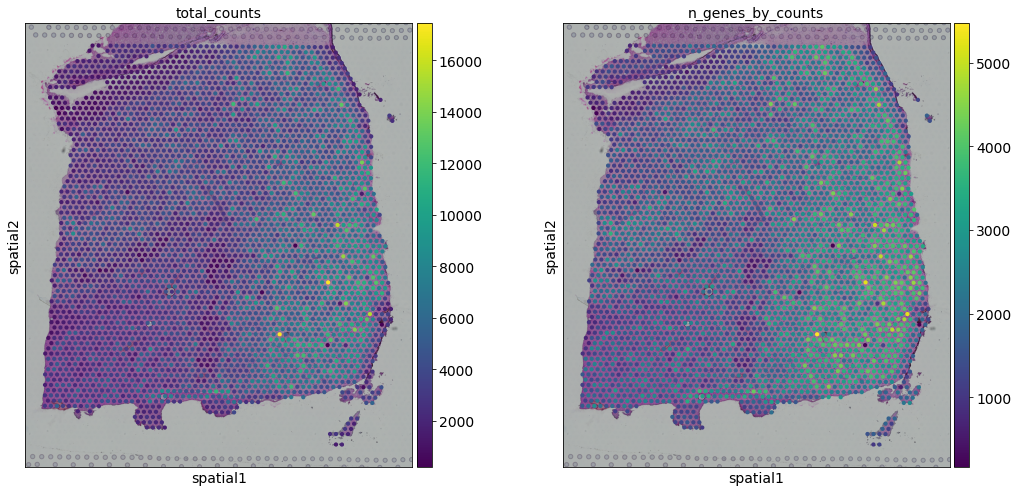

In [69]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

In [107]:
adata.uns['spatial']['151673'].keys()

dict_keys(['images', 'metadata', 'scalefactors'])

In [111]:
adata.shape

(3639, 16578)

In [104]:
adata.obsm['spatial']

array([[ 9791,  8468],
       [ 5769,  2807],
       [ 4068,  9505],
       ...,
       [ 4631,  7831],
       [ 5571, 11193],
       [ 6317,  3291]])

In [102]:
data_points = [np.array(adata.obsm['spatial'])[:, 0 : 2]]

In [108]:
# 获得坐标位置
# 查看源代码：spatial-> embedding -> _get_data_points -> 1009到1014行代码
scale_factor = adata.uns['spatial']['151673']['scalefactors']['tissue_hires_scalef']

data_points[0] = np.multiply(data_points[0], scale_factor)

In [119]:
poss = data_points[0].astype(int)
# poss[:,0] - X axis, poss[:,1] - Y axis

In [120]:
poss


array([[1468, 1270],
       [ 865,  421],
       [ 610, 1425],
       ...,
       [ 694, 1174],
       [ 835, 1679],
       [ 947,  493]])

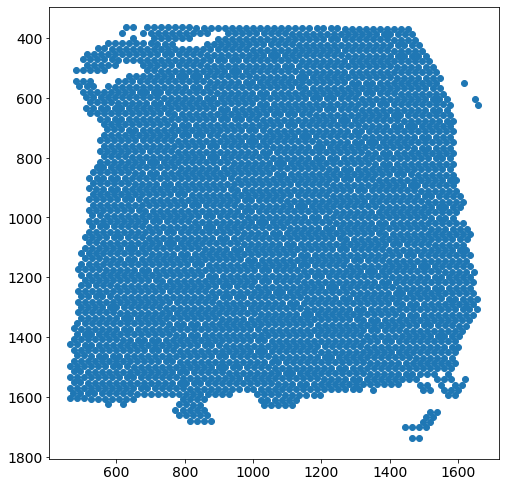

In [125]:
plt.scatter(poss[:,0],poss[:,1])
plt.gca().invert_yaxis()
plt.grid(None)

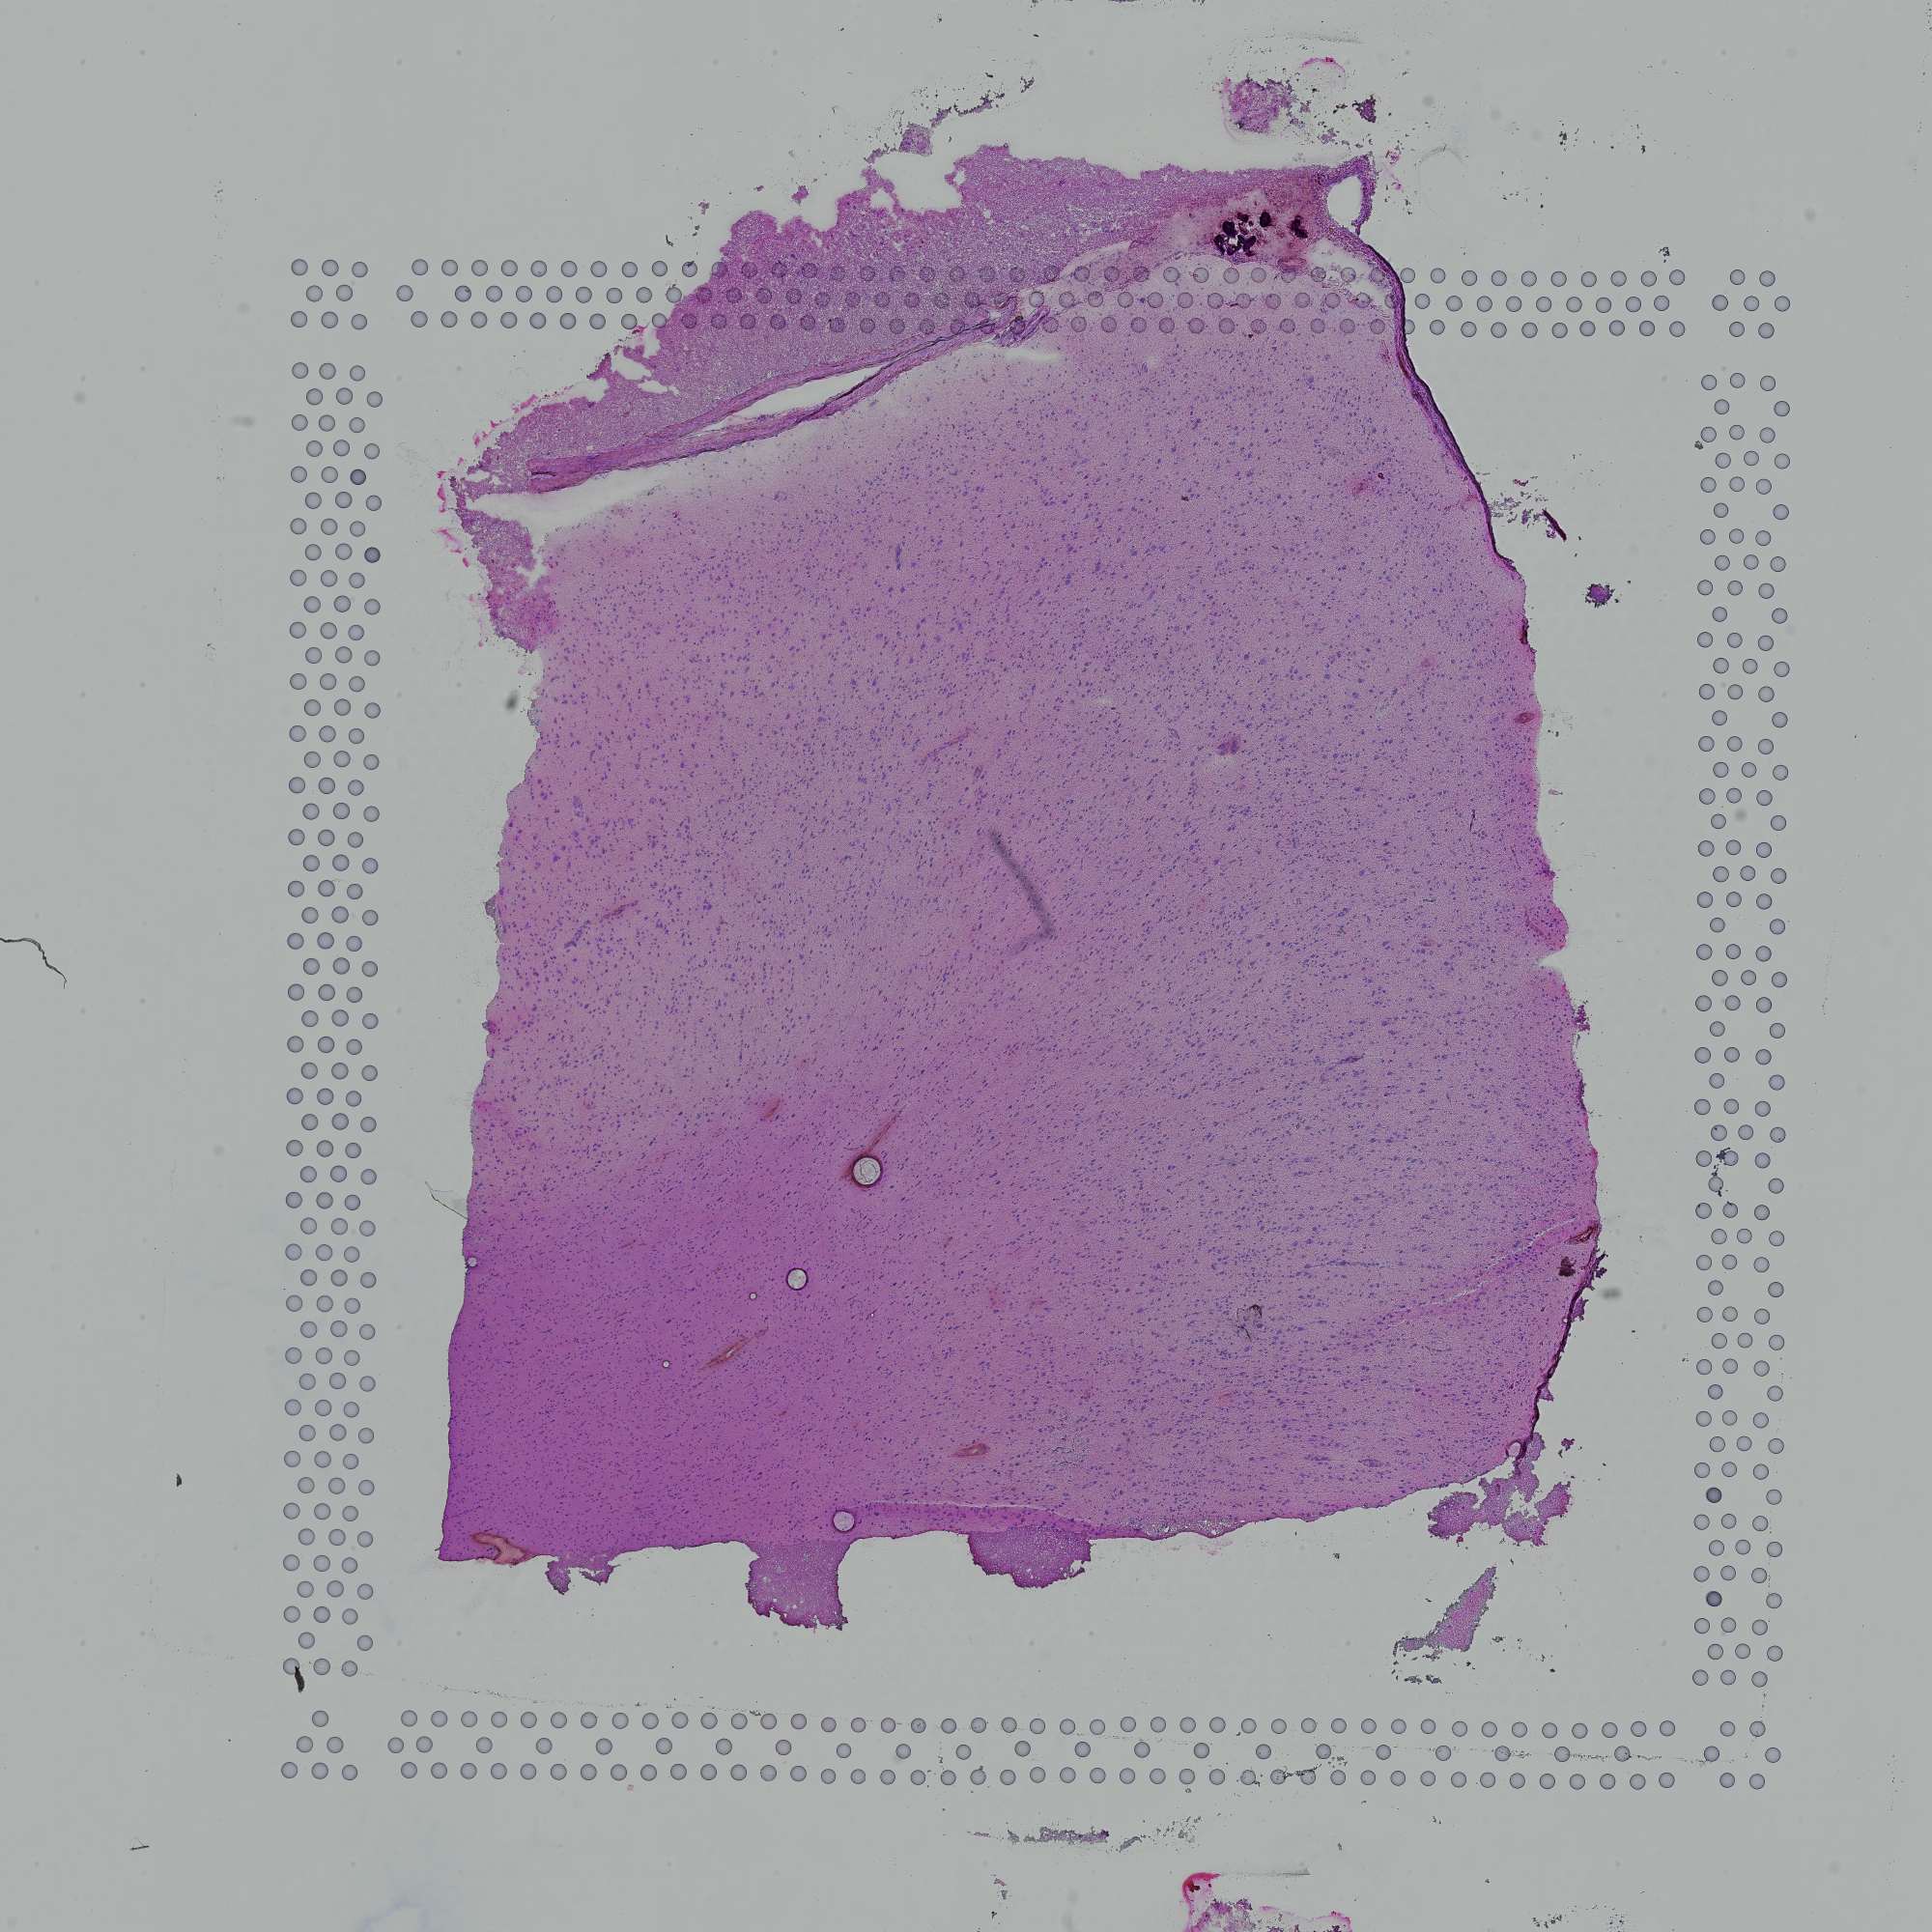

In [92]:
im_array=adata.uns['spatial']['151673']['images']['hires']
im = Image.fromarray(np.uint8(im_array*255))
im

In [85]:
adata.uns['spatial']['151673']

{'chemistry_description': 'custom', 'software_version': '4509.5.5'}

In [86]:
# # spot size
# size * spot_size * scale_factor
adata.obsm['spatial']

array([[ 9791,  8468],
       [ 5769,  2807],
       [ 4068,  9505],
       ...,
       [ 4631,  7831],
       [ 5571, 11193],
       [ 6317,  3291]])

In [80]:
adata.uns['spatial'].keys()

dict_keys(['151673'])

In [25]:
adata

View of AnnData object with n_obs × n_vars = 4226 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

In [70]:
min(np.array(adata.obsm['spatial'])[:,0]),max(np.array(adata.obsm['spatial'])[:,1]),

(3096, 11584)